# Mining Massive Dataset - Project

Source : Collaborative Filtering with Temporal Dynamics with Using Singular Value Decomposition - Cigdem BAKIR (Netflix dataset)
___

Our Datasets :

MovieLens 25M : https://grouplens.org/datasets/movielens/25m/

Amazon Movies and TV - ratings only : https://nijianmo.github.io/amazon/index.html

In [1]:
import pandas as pd

names = ['userID', 'itemID', 'rating', 'timestamp']

df = pd.read_csv('ratings.csv') ; df.columns = names

#df = pd.read_csv('Movies_and_TV.csv', header=None, names=names)

In [2]:
print(df['rating'].min(), df['rating'].max())
df.head()

0.5 5.0


,userID,itemID,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [3]:
def add_age(df):
  df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
  last = df['datetime'].max()
  df['Age_r'] = (last - df['datetime']).dt.days / 365.25 # age in years
  return df

df = add_age(df)

In [4]:
print(df.groupby('userID').size().median())
df.head()

71.0


,userID,itemID,rating,timestamp,datetime,Age_r
0,1,296,5.0,1147880044,2006-05-17 15:34:04,13.511294
1,1,306,3.5,1147868817,2006-05-17 12:26:57,13.511294
2,1,307,5.0,1147868828,2006-05-17 12:27:08,13.511294
3,1,665,5.0,1147878820,2006-05-17 15:13:40,13.511294
4,1,899,3.5,1147868510,2006-05-17 12:21:50,13.511294


In [5]:
age_max = 2
filtered_df = df.copy()

idx = df.groupby(['userID', 'itemID'])['Age_r'].idxmin()
filtered_df = filtered_df.loc[idx].copy() # if a user rated the same item more than once we chose the last one

filtered_df = filtered_df[filtered_df['Age_r'] < age_max]

print("user*item all ratings : ", df['userID'].nunique(), df['itemID'].nunique())
print(f"user*item last {age_max} years ratings : ", filtered_df['userID'].nunique(), filtered_df['itemID'].nunique())

top_items = filtered_df['itemID'].value_counts().head(3000).index
filtered_df = filtered_df[filtered_df['itemID'].isin(top_items)]

top_users = filtered_df['userID'].value_counts().head(15000).index
filtered_df = filtered_df[filtered_df['userID'].isin(top_users)]

print("user*item final filtering : ", filtered_df['userID'].nunique(), filtered_df['itemID'].nunique())
print(filtered_df.groupby('userID').size().median())

user*item all ratings :  162541 59047
user*item last 2 years ratings :  19297 49920
user*item final filtering :  15000 3000
82.5


Traditional Item Based CF

In [9]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

def weight_ratings(df, n, m):
  df['rating'] = df['rating'] / (m * df['Age_r'] + n) # temporal dynamics
  df['rating'] = 5 * df['rating'] / df['rating'].max() # rescaling
  return df

def train_test_split(df, n=0, m=1, age_threshold=3/12):
    user_item = df.pivot_table(index='userID', columns='itemID', values='rating', fill_value=0)
    users = user_item.index
    items = user_item.columns

    train_df = df[df['Age_r'] >= age_threshold].copy()
    test_df = df[df['Age_r'] < age_threshold].copy()

    if n != 0 and m != 1:
        train_df = weight_ratings(train_df, n, m)
    train = train_df.pivot_table(index='userID', columns='itemID', values='rating', fill_value=0)
    test = test_df.pivot_table(index='userID', columns='itemID', values='rating', fill_value=0)
        
    train = train.reindex(index=users, columns=items, fill_value=0).values
    test = test.reindex(index=users, columns=items, fill_value=0).values

    # Test and training are truly disjoint
    assert(np.all((train * test) == 0))
    return train, test


def compute_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

def predict_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([similarity.sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([similarity.sum(axis=1)])

def get_rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

def standardize(train):
    train_std = train.copy().astype(float)
    user_means = []
    user_stds = []
    for i in range(train_std.shape[0]):
        row = train_std[i, :]
        mask = row != 0
        count = np.count_nonzero(mask)
        if count == 0:
            mean = 0.0
            std = 1.0
        else:
            mean = row[mask].mean()
            std = row[mask].std()
            if std == 0:
                std = 1.0 # iif the user rated all item the same score
        # std = 1 iif only centering
        user_means.append(mean)
        user_stds.append(std)
        train_std[i, mask] = (row[mask] - mean) / std
    return train_std, np.array(user_means), np.array(user_stds)

def destandardize(predictions, user_means, user_stds):
    pred_destandardized = predictions.copy()
    for i in range(predictions.shape[0]):
        pred_destandardized[i, :] = user_stds[i] * pred_destandardized[i, :] + user_means[i]
    return pred_destandardized

def predictions_rescaled(predictions, new_min=0.5, new_max=5):
    old_min = np.min(predictions)
    old_max = np.max(predictions)
    scaled = (predictions - old_min) / (old_max - old_min)
    return scaled * (new_max - new_min) + new_min

"""
# First version - No standardizing

train, test = train_test_split(filtered_df)
item_similarity = compute_similarity(train, kind='item')
item_prediction = predict_simple(train, item_similarity, kind='item')
"""

train, test = train_test_split(filtered_df)
train_std, user_means, user_stds = standardize(train)
item_similarity = compute_similarity(train_std, kind='item')
item_prediction_std = predict_simple(train_std, item_similarity, kind='item')
item_prediction = destandardize(item_prediction_std, user_means, user_stds)
item_prediction = predictions_rescaled(item_prediction)

error_rate = 100 * get_rmse(item_prediction, test) / 5
print('Traditional Item Based CF Error Rate (%): ', error_rate)

Traditional Item Based CF Error Rate (%):  24.004540628340592


In [10]:
total = train + test
nb_total = np.count_nonzero(total)
nb_train = np.count_nonzero(train)
nb_test = np.count_nonzero(test)
sparsity = 1 - (nb_total / total.size)

print(f"Total ratings       : {nb_total}")
print(f"Sparsity       : {sparsity:.2%}")
print(f"Train ratings (old) : {nb_train} ({nb_train / nb_total:.2%})")
print(f"Test ratings  (recent)    : {nb_test} ({nb_test / nb_total:.2%})")

Total ratings       : 2176187
Sparsity       : 95.16%
Train ratings (old) : 1914087 (87.96%)
Test ratings  (recent)    : 262100 (12.04%)


In [11]:
print(filtered_df['Age_r'].max())

1.998631074606434


RMSE error rate obtained with temporal dynamics item-based CF


31.470098039521115
35.61236178219926
20.797308506113048
44.767539249749895
22.46723891030171
35.0383214080329
25.014463414396282
24.25388342621853
21.226327929090477
33.60849064002515
25.091148863681685
39.27153098800581
21.330954636337594
30.786753644634956
22.45120626000403
21.674588343957286
33.17034057043229
23.729870129640002
20.38061232811822
27.407918622097675
29.548579622522944


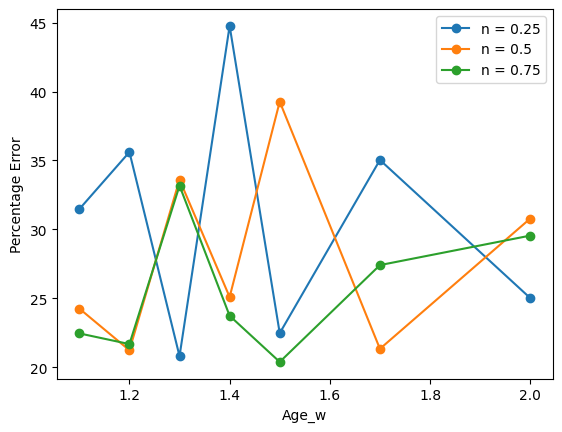

In [12]:
import matplotlib.pyplot as plt

Age_w = [1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 2]
n_values = [0.25, 0.5, 0.75]
m_values = []
for i in range(len(n_values)):
  m_values.append([])
  for age in Age_w:
    m_values[i].append((age-n_values[i]) / 2)

Error_rate = []

n0, m0 = n_values[0], m_values[0][0] # n and m that minimize error rate

for i in range(len(n_values)) :
  Error_rate.append([])
  for j in range(len(m_values[i])) :
    temp_df = filtered_df.copy()

    train, test = train_test_split(temp_df, n=n_values[i], m=m_values[i][j])
    train_std, user_means, user_stds = standardize(train)
    item_similarity = compute_similarity(train_std, kind='item')
    item_prediction_std = predict_simple(train_std, item_similarity, kind='item')
    item_prediction = destandardize(item_prediction_std, user_means, user_stds)
    item_prediction = predictions_rescaled(item_prediction)
    error_rate = 100 * get_rmse(item_prediction, test) / 5

    print(error_rate)

    Error_rate[i].append(error_rate)

    if n_values[i] == n0 and m_values[i][j] == m0 :
      error_rate0 = error_rate
    if error_rate < error_rate0 :
      n0, m0 = n_values[i], m_values[i][j]
      error_rate0 = error_rate

  plt.plot(Age_w, Error_rate[i], marker='o', label=f'n = {n_values[i]}')

plt.xlabel('Age_w')
plt.ylabel('Percentage Error')
plt.legend()
plt.show()

In [13]:
print(n0, m0, error_rate0)

0.75 0.375 20.38061232811822


Item based with temporal dynamics combined SVD and item based combined SVD

31.90604306380523
21.261571670743947
24.2421836183247
21.95155821588347
31.498838912601165
30.572561288361634
34.78757836674728
29.19828644444532
32.524620782007915
34.058789124571675
35.180067223947944
43.68999206344755
21.069639545093377
26.864206066971537


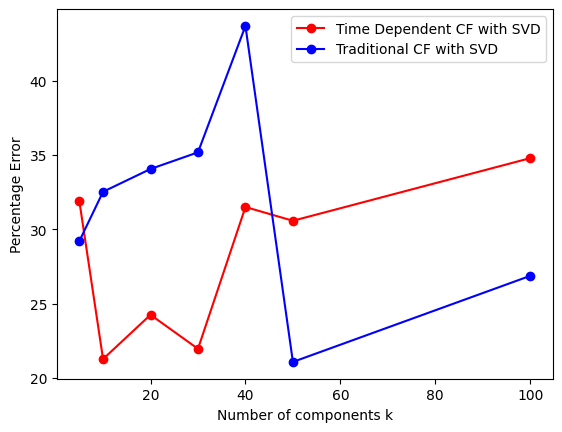

In [14]:
from sklearn.decomposition import TruncatedSVD

k_values = [5, 10, 20, 30, 40, 50, 100]

Error_rate_time = []
Error_rate_trad = []

for i in range(2):
    temp_df = filtered_df.copy()
    if i == 0 : 
        train, test = train_test_split(temp_df, n=n0, m=m0) # First : Temporal Dynamics CF
    else :
        train, test = train_test_split(temp_df) # Second : Traditional CF
    
    for k in k_values:
        svd = TruncatedSVD(n_components=k, random_state=42)

        U = svd.fit_transform(train)
        Vt = svd.components_
        train_approx = np.dot(U, Vt)

        train_std, user_means, user_stds = standardize(train_approx)
        item_similarity = compute_similarity(train_std, kind='item')
        item_prediction_std = predict_simple(train_std, item_similarity, kind='item')
        item_prediction = destandardize(item_prediction_std, user_means, user_stds)
        item_prediction = predictions_rescaled(item_prediction)
        error_rate = 100 * get_rmse(item_prediction, test) / 5
        print(error_rate)

        if i == 0 : 
            Error_rate_time.append(error_rate) # First : Temporal Dynamics CF
        else :
            Error_rate_trad.append(error_rate) # Second : Traditional CF

plt.plot(k_values, Error_rate_time, marker='o', color='red', label='Time Dependent CF with SVD')
plt.plot(k_values, Error_rate_trad, marker='o', color='blue', label='Traditional CF with SVD')

plt.xlabel('Number of components k')
plt.ylabel('Percentage Error')
plt.legend()
plt.show()

Traditional Item based CF and item based CF with temporal dynamics results by taking neighborhoods

47.62355757253316
48.795908786749
55.25785017175657
59.95587241869306
62.535340857697534
20.638473193996575
24.139632160548622
20.505561464994056
51.4313024659823
20.25356894026874
21.261571670743947
45.594277409778826
61.38551275645062
61.38802167379623
61.38922280104871
61.38972176472604
61.389641789081374
61.388740195685386
61.36894254053904
55.56642767277191
38.63092839052816
24.004540628340592


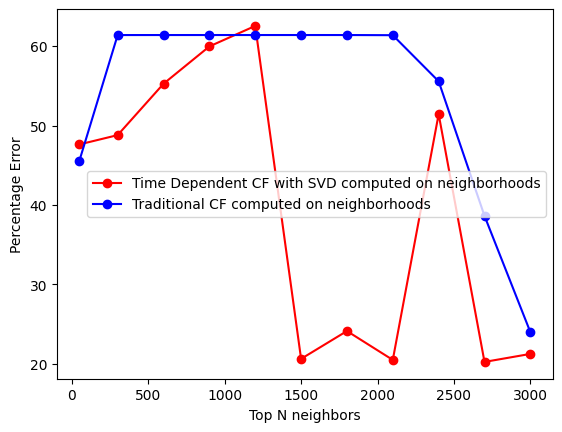

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

def top_N_similarity_matrix(similarity_matrix, N):
    n_items = similarity_matrix.shape[0]
    reduced_sim = np.zeros_like(similarity_matrix)
    for i in range(n_items):
        sim_row = similarity_matrix[i].copy()
        sim_row[i] = -np.inf  # ignore self-similarity

        top_N_idx = np.argpartition(sim_row, -N)[-N:]
        for j in top_N_idx:
            reduced_sim[i, j] = similarity_matrix[i, j]

    return reduced_sim


k0 = 10
Error_rate_time = []
Error_rate_trad = []
N_values = [50, 300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000]

svd = TruncatedSVD(n_components=k0, random_state=42)

for i in range(2):
    temp_df = filtered_df.copy()
    if i == 0 : 
        train, test = train_test_split(temp_df, n=n0, m=m0) # First : Temporal Dynamics CF
        U = svd.fit_transform(train)
        Vt = svd.components_
        train = np.dot(U, Vt)
    else :
        train, test = train_test_split(temp_df) # Second : Traditional CF

    train_std, user_means, user_stds = standardize(train)
    item_similarity = compute_similarity(train_std, kind='item')

    for N in N_values :
        top_N_item_similarity = top_N_similarity_matrix(item_similarity, N) # Similarity on the neighborhood
        item_prediction_std = predict_simple(train_std, top_N_item_similarity, kind='item')
        item_prediction = destandardize(item_prediction_std, user_means, user_stds)
        item_prediction = predictions_rescaled(item_prediction)
        error_rate = 100 * get_rmse(item_prediction, test) / 5
        print(error_rate)

        if i == 0 : 
            Error_rate_time.append(error_rate) # First : Temporal Dynamics CF
        else :
            Error_rate_trad.append(error_rate) # Second : Traditional CF


plt.plot(N_values, Error_rate_time, marker='o', color='red', label='Time Dependent CF with SVD computed on neighborhoods')
plt.plot(N_values, Error_rate_trad, marker='o', color='blue', label='Traditional CF computed on neighborhoods')

plt.xlabel('Top N neighbors')
plt.ylabel('Percentage Error')
plt.legend()
plt.show()